# SAKI SS19 - adorsys Transaction Classification Challenge

### Objective
For a given set of financial transactions, classify each one into one of seven revenue (transaction) categories; these
categories are:
* Income
* Private (cash, deposit, donation, presents)
* Living (rent, additional flat expenses, ...)
* Standard of living (food, health, children, ...)
* Finance (credit, bank costs, insurances, savings)
* Leisure (hobby, sport, vacation, shopping, ...)

### Data Acquisition
* We start by importing our data with pandas and we print some information about the dataset.

In [36]:
import pandas as pd

PATH_TO_DATA = "data/training_validation.csv"
PATH_TO_TEST_DATA = "data/test.csv"

dataSet = pd.read_csv(PATH_TO_DATA, delimiter=',')
testDataSet = pd.read_csv(PATH_TO_DATA, delimiter=',')


### Sampling
In order to avoid any assumptions that can be made about the data, we randomly split the data into
training and test sets.
For each class, we hold 85% for training and 15% for test (since our data set is small). This ensures that we don't completely delete
a certain label after sampling. More over, as we will see later, our labels are imbalanced; this sampling method 
also enforces fairness during as the split.
The test data is then saved in a different csv files.

Note that the code for sampling is merely provided for transparency. That is why it is commented. I executed the code
once and saved my training-validation and test set separately. Hence, the whole notebook comments below assume you
trained and tested the model with my initial partitions. Re-sampling the the data might yield different results.


In [37]:
from collections import Counter
from imblearn.datasets import make_imbalance

def ratio_multiplier(label_values: pd.DataFrame):
    
    labels_statistics = Counter(label_values)
    labels_multiplier_ratios = dict.fromkeys(labels_statistics.keys(), 0.15)
    
    for label, weight in labels_statistics.items():
        labels_statistics[label] = int(weight * labels_multiplier_ratios[label])
        
    return labels_statistics


In [38]:
# allLabels = dataSet["label"].copy()
# rowIdentifiers = pd.concat([dataSet["Unnamed: 0"].copy(), dataSet["Unnamed: 0"].copy()], axis=1, sort=False)
# comment: If is seems confusing, it is normal. make_balances expects a 2D data set of numbers. So I just duplicated
# comment: the identifier attribute. We need these identifies to determine which rows belong to the test and training sets.

# testIdentifiers, _ = make_imbalance(rowIdentifiers, allLabels, sampling_strategy=ratio_multiplier)

# comment: below are the row indexes belonging to the test set
# testRowIds = [i[0] for i in testIdentifiers]

# comment: below are the row indexes belonging to the training set set
# trainingRowIds = [i for i in range(0, len(dataSet)) if i not in testRowIds]

# testSet = dataSet.iloc[testRowIds]
# trainingValidationSet: pd.DataFrame = dataSet.iloc[trainingRowIds]

# print("Training and Validattion set: " + str(trainingValidationSet.shape))
# print("Test set: " + str(testSet.shape))

# trainingValidationSet.to_csv("./data/training_validation.csv", index=False)

# testSet.to_csv("./data/test.csv", index=False)


### Data Exploration
* To obtain a better understanding of our data, we need to do some exploration.
* One might argue that some the tasks performed here belong to feature engineering or to another machine learning phase, 
    and the argument would be legitimate. It is merely done here to explore the data unencumbered.
* Going onwards, every function applied to the training set is also applied to the test set on the fly. But note that
the test set has no influence on the pipeline. The test set just need to be in the same format as the training
 set during inference.


1. Removing the columns with little or no value
The following columns might not be very useful for our model training:


- **Auftragskonto**: Is the account number of the person or entity that performs the transaction. You can
see that there are just a few account numbers.


In [39]:
uniqueAccountNumbers = len(dataSet["Auftragskonto"].unique())
missingAccountNumbers = dataSet["Auftragskonto"].isnull().sum()

print("There are " + str(uniqueAccountNumbers) + " unique account numbers.")
print("There are " + str(missingAccountNumbers) + " missing values.")


There are 3 unique account numbers.
There are 37 missing values.


- **Unnamed:0**: Is just a row identifier


- **Valutadatum**: Valutadatum and Buchungstag have the same values except for one. However, Valutadatum is discarded
 since (in my opinion, semantically) would correspond to the actual date of the transaction.
 

In [40]:
sameDateOnBothColumns = dataSet[dataSet["Valutadatum"] != dataSet["Buchungstag"]]
print("How many rows have different dates ? " + str(len(sameDateOnBothColumns)))


How many rows have different dates ? 1


- **Kontonummer and BLZ**: Both values generally tie to a bank a specific account in a bank branch. The same bank 
in different cities might have different BLZ. My assumption is that these values may over fit the
model on the training set.

- **Waehrung**: This is the currency and given our data, it might not be very helpful during predictions.

In [41]:
uniqueCurrencies = len(dataSet["Waehrung"].unique())
print("There is only " + str(uniqueCurrencies) + " currency.")


There is only 1 currency.


In [42]:
def get_dataset_with_meaningful_columns(data: pd.DataFrame) -> pd.DataFrame:
    return data.drop(columns=["Auftragskonto", "Unnamed: 0", "Valutadatum",
                                                     "Kontonummer", "BLZ", "Waehrung"])

dataSetWithMeaningfulColumns = get_dataset_with_meaningful_columns(dataSet)
testDataSetWithMeaningfulColumns = get_dataset_with_meaningful_columns(testDataSet)

dataSetWithMeaningfulColumns.head()


,Buchungstag,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Betrag,label
0,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,2000.00,income
1,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,-670.00,living
2,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,-70.00,private
3,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,-73.21,standardOfLiving
4,18.07.2016,Spontanausgabe,Amazon,neue Playstation,-363,leisure


2. Searching for outliers  
Now, let us search for outliers in the **Betrag** column. We start by plotting a box plot for this attribute.
(Some cleaning has to be done on the amount as some numbers have commas while others have a dot for floating points.)


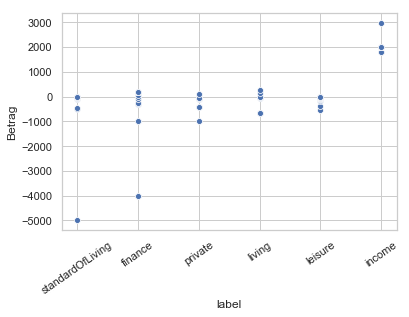

In [43]:
import seaborn as sns
sns.set(style="whitegrid")

def transform_amount_feature(data: pd.DataFrame) -> pd.DataFrame:
    data["Betrag"] = data["Betrag"].apply(lambda amount: amount.replace(',','.'))
    data["Betrag"] = data["Betrag"].astype("float")
    
    return data["Betrag"]
    
dataSetWithMeaningfulColumns["Betrag"] = transform_amount_feature(dataSetWithMeaningfulColumns)
testDataSetWithMeaningfulColumns["Betrag"] = transform_amount_feature(testDataSetWithMeaningfulColumns)

dataSetWithMeaningfulColumns["label"] = dataSetWithMeaningfulColumns["label"].astype("category")
testDataSetWithMeaningfulColumns["label"] = testDataSetWithMeaningfulColumns["label"].astype("category")

amountVsLabelPlot = sns.scatterplot(x="label", y="Betrag", data=dataSetWithMeaningfulColumns.sort_values("Betrag"))

def rotate_labels(plot):
    for item in plot.get_xticklabels():
        item.set_rotation(35)
rotate_labels(amountVsLabelPlot)

On the first sight, it looks like the points at -5000€ and -4000€ could be outliers. 
However, -4000€ falls in the finance category. After investigation, we notice that it is indeed a money investment. 
We are therefore left with the former case (-5000€). Before drawing any conclusions we draw another plot based on 
the days of the month.


In [44]:
missingAccountNumbers = dataSet["Buchungstag"].isnull().sum()
print("There are " + str(missingAccountNumbers) + " missing dates.")


There are 0 missing dates.


I speculate that the full date will not be useful for categorization. The day of the month however can have some interesting
properties. For example, regular worker salaries usually come up around the end of the month (or at the beginning of the new month). For
this reason, a new attribute **dayOfMonth** is created and meanwhile **Buchungstag** will be discarded. 
There are no missing values, so one can safely extract the day.


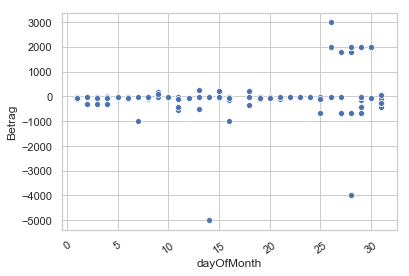

In [45]:
def get_dataset_with_day_of_month(data: pd.DataFrame) -> pd.DataFrame:
    data["dayOfMonth"] = data["Buchungstag"].apply(lambda date: date[0:2]) 
    data["dayOfMonth"] = data["dayOfMonth"].astype("int")
    return data["dayOfMonth"]

dataSetWithMeaningfulColumns["dayOfMonth"] = get_dataset_with_day_of_month(dataSetWithMeaningfulColumns)
testDataSetWithMeaningfulColumns["dayOfMonth"] = get_dataset_with_day_of_month(testDataSetWithMeaningfulColumns)

dayVsAmountPlot = sns.scatterplot(x="dayOfMonth", y="Betrag", data=dataSetWithMeaningfulColumns.sort_values("dayOfMonth"))

rotate_labels(dayVsAmountPlot)


As expected, a lot more happens towards the end of the months. The transaction with -5000€ still stands out.


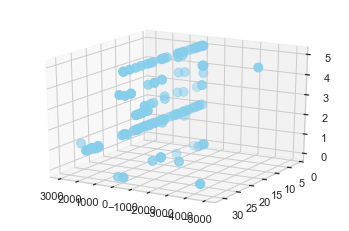

In [46]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataSetWithMeaningfulColumns["Betrag"], dataSetWithMeaningfulColumns["dayOfMonth"], dataSetWithMeaningfulColumns["label"].cat.codes, c='skyblue', s=80)
ax.view_init(20, 120)
plt.show()

After plotting the day against the amount and label (irrespective of their encoding 0-5) I assume that
the transaction with -5000€ is an outlier. It does not quite fit to the other points belonging to the category 
standardOfLiving. For this reason, this row will be removed before training.


In [47]:
print("Shape before removing outliers" + str(dataSetWithMeaningfulColumns.shape))
dataSetWithoutOutlier = dataSetWithMeaningfulColumns[dataSetWithMeaningfulColumns["Betrag"] > -5000]
print("Shape after removing outliers" + str(dataSetWithoutOutlier.shape))


Shape before removing outliers(181, 7)
Shape after removing outliers(180, 7)


3. We now look at the distribution of **Betrag**. Having a normal distribution could be important
if we decide to chose a classifier which assumes normality (Gaussian Naive Bayes in our case). 


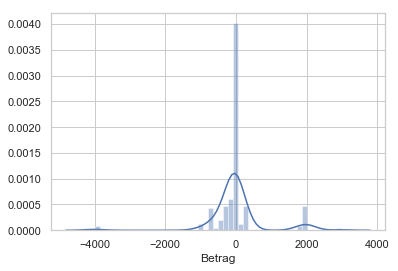

In [48]:
ax = sns.distplot(dataSetWithoutOutlier["Betrag"])

The histogram tells us that cash outflows are more frequent than inflows. We can also look at the mean and median.


In [49]:
print("The mean of Betrag is: " + str(dataSetWithoutOutlier["Betrag"].mean(skipna=True)))
print("The median of Betrag is " + str(dataSetWithoutOutlier["Betrag"].median(skipna=True)))


The mean of Betrag is: 23.50427777777778
The median of Betrag is -28.85


4. At last we look at the distribution of the labels in our dataset


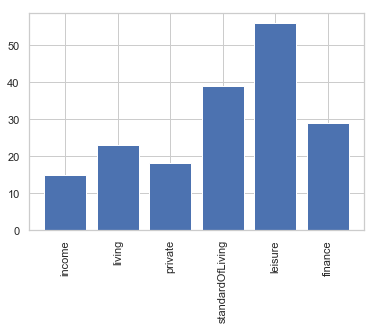

In [50]:
from collections import Counter
import numpy as np
def plot_frequencies(data):
    counter = Counter(data)
    tokens = counter.keys()
    token_counts = counter.values()
    indexes = np.arange(len(tokens))
    plt.bar(indexes, token_counts)
    plt.xticks(indexes, tokens, rotation="vertical")
    plt.show()
plot_frequencies(dataSetWithoutOutlier["label"])


This plot shows that our labels are imbalanced; something to considered when sampling the data.


### Data Cleaning
* Two main attributes will be involved (**Verwendungszweck** and **Buchungstext**)
* All non alphabetical characters are deleted from the **Buchungstext** so that we keep (more or less) full words or tokens
* As for the Verwendungszweck, more work has to be done.
    * Then replace all non alphabetical characters with spaces. For example "A/9B" will then be "A  B"
    * At last, stopwords (assuming german language) are removed and german characters are normalized (i.e ä to ae etc.). 
    

In [51]:
def replace_non_alpha_with_space(text: str):
    return "".join([c if c.isalpha() else " " for c in text])

def normalize_german_characters(text: str):
    text = text.replace('ä', 'ae')
    text = text.replace('ö', 'oe')
    text = text.replace('ü', 'ue')
    text = text.replace('Ä', 'Ae')
    text = text.replace('Ö', 'Oe')
    text = text.replace('Ü', 'Ue')
    text = text.replace('ß', 'ss')
    return text

def remove_words_from_text(text: str, words: list):
    return " ".join([token for token in text.lower().split() if token not in words])

def remove_one_and_two_char_tokens(text: str):
    return " ".join([token for token in text.split() if len(token) > 2])

from nltk.corpus import stopwords
germanStopWords = stopwords.words('german')

def get_clean_buchungs_text(data: pd.DataFrame) -> pd.DataFrame:
    data.Buchungstext = data.Buchungstext.apply(lambda text: replace_non_alpha_with_space(text))
    data.Buchungstext = data.Buchungstext.apply(lambda text: remove_words_from_text(text, germanStopWords))
    data.Buchungstext = data.Buchungstext.apply(lambda text: normalize_german_characters(text))
    return data.Buchungstext


def get_clean_transaction_purpose_text(data: pd.DataFrame) -> pd.DataFrame:
    data.Verwendungszweck = data.Verwendungszweck.apply(lambda text: replace_non_alpha_with_space(text))
    data.Verwendungszweck = data.Verwendungszweck.apply(lambda text: normalize_german_characters(text))
    return data.Verwendungszweck
    
dataSetWithoutOutlier.Buchungstext = get_clean_buchungs_text(dataSetWithoutOutlier)
testDataSetWithMeaningfulColumns.Buchungstext = get_clean_buchungs_text(testDataSetWithMeaningfulColumns)

dataSetWithoutOutlier.Verwendungszweck = get_clean_transaction_purpose_text(dataSetWithoutOutlier)
testDataSetWithMeaningfulColumns.Verwendungszweck = get_clean_transaction_purpose_text(testDataSetWithMeaningfulColumns)

dataSetWithoutOutlier.head()


/Users/pascalzoleko/PycharmProjects/saki2019/venv/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Buchungstag,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Betrag,label,dayOfMonth
0,28.07.2016,lohn gehalt,Gehalt Adorsys GmbH Co KG End To End Ref ...,Adorsys GmbH & Co. KG,2000.00,income,28
1,27.07.2016,miete,Byladem Sbt De Miete Beuth...,Georg Tasche,-670.00,living,27
2,21.07.2016,bargeld,Uhr Nuernberg All Eur Geb Eur...,Bargeld,-70.00,private,21
3,20.07.2016,lebensmittel getraenke,Edeka Neubauer Nuernb Nuernb ...,Kartenzahlung,-73.21,standardOfLiving,20
4,18.07.2016,spontanausgabe,Amazon,neue Playstation,-363.00,leisure,18


We now look at how the words are distributed for each variable.
* For **Buchungstext**


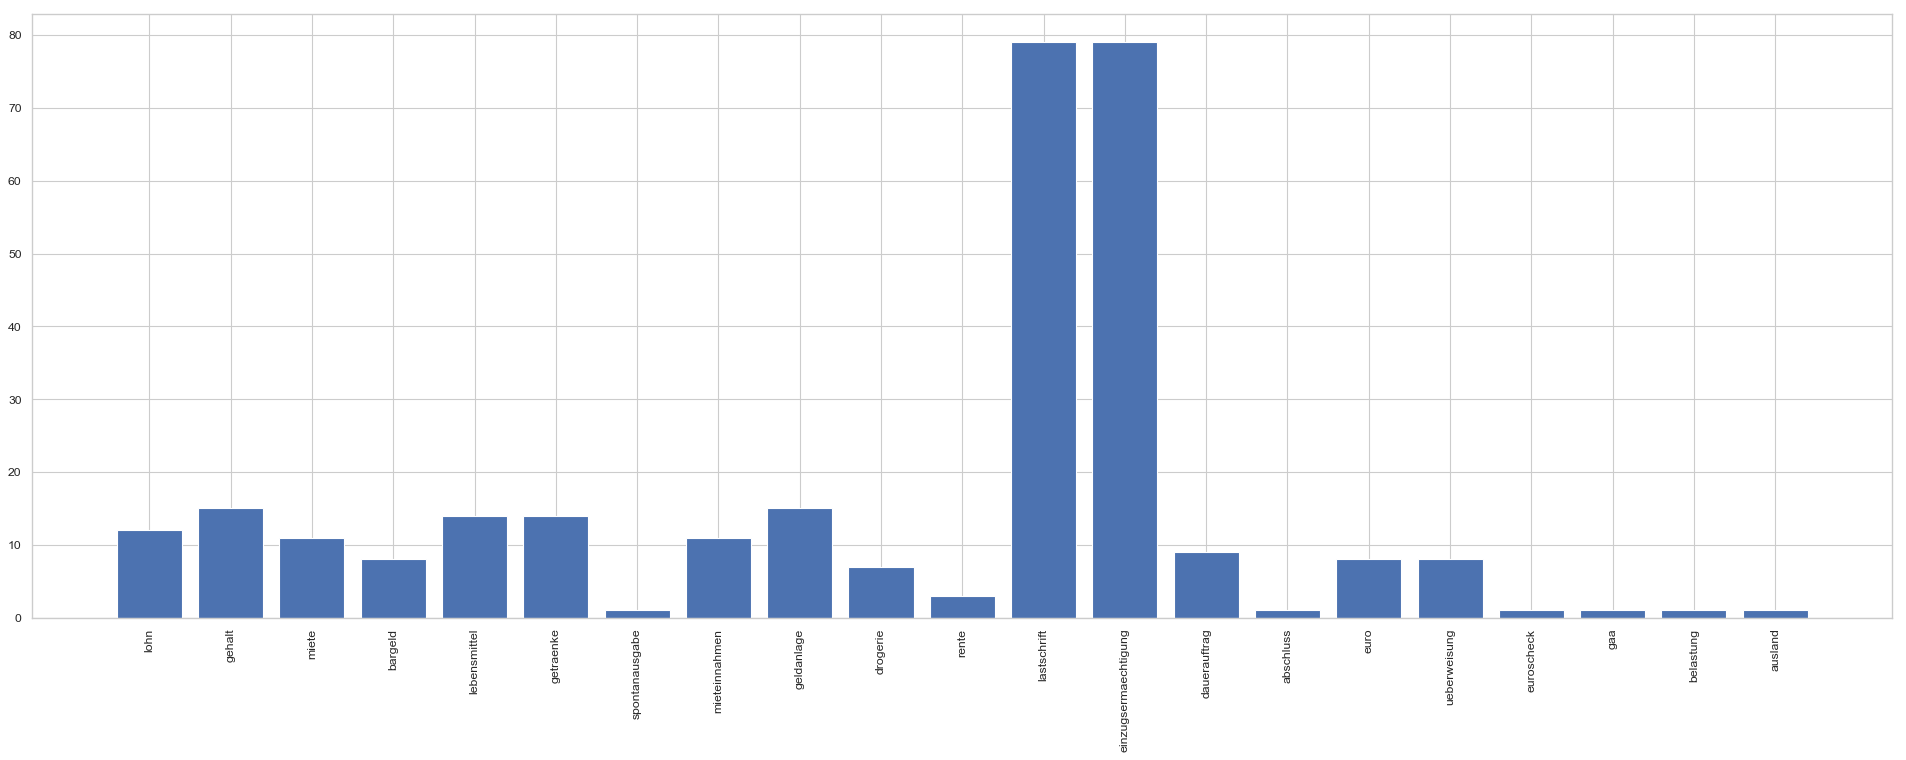

In [52]:
from matplotlib.pyplot import figure
def plot_token_frequencies(data):
    figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
    plot_frequencies([token for i, text in enumerate(data) for token in text.split()])
plot_token_frequencies(dataSetWithoutOutlier["Buchungstext"])

* For **Verwendungszweck**


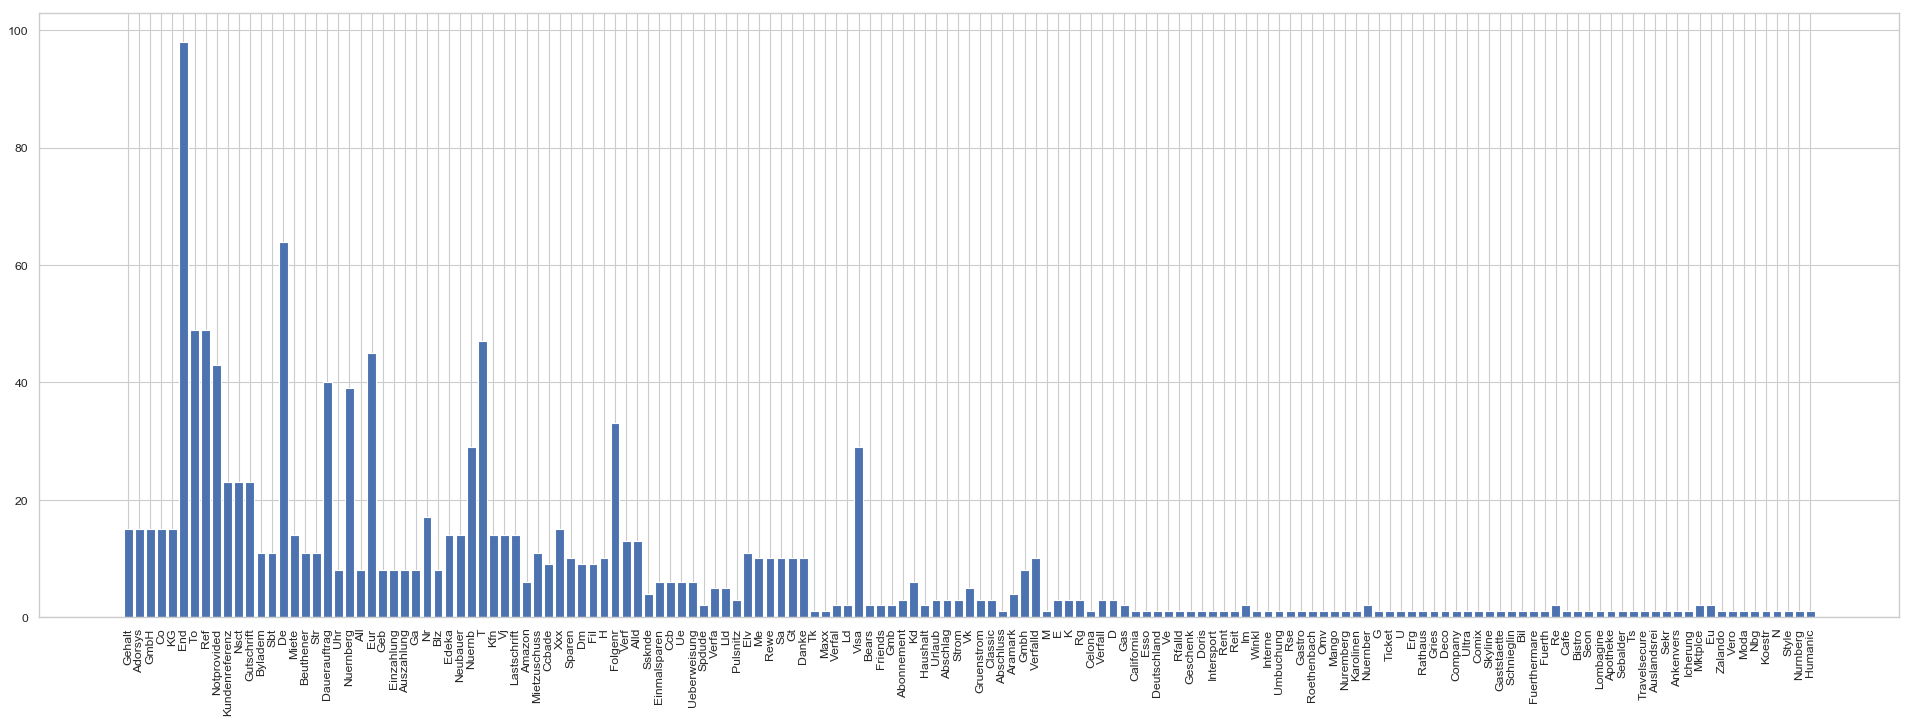

In [53]:
plot_token_frequencies(dataSetWithoutOutlier["Verwendungszweck"])

After taking a look at the distribution, one might notice that many words with higher frequencies tend to be less
relevant (in my opinion, based on transaction semantics) when compared to some words having lower frequencies. 
I will also assume that one and two character tokens won't be very useful for the model, since they hold no semantical
meaning (in my opinion).


In [54]:
dataSetWithoutOutlier.Verwendungszweck = dataSetWithoutOutlier.Verwendungszweck.apply(lambda text: remove_one_and_two_char_tokens(text))
testDataSetWithMeaningfulColumns.Verwendungszweck = testDataSetWithMeaningfulColumns.Verwendungszweck.apply(lambda text: remove_one_and_two_char_tokens(text))


Given that the space of words is small, i can afford to manually select words I deem relevant for the classifier. 
The selection is merely based on intuition and other factors (online search, IBAN/BICs, redundant 
tokens e.g "bears friends" etc.).
The following words are most likely going to overfit the model and hence will be deleted from the Verwendungszweck.


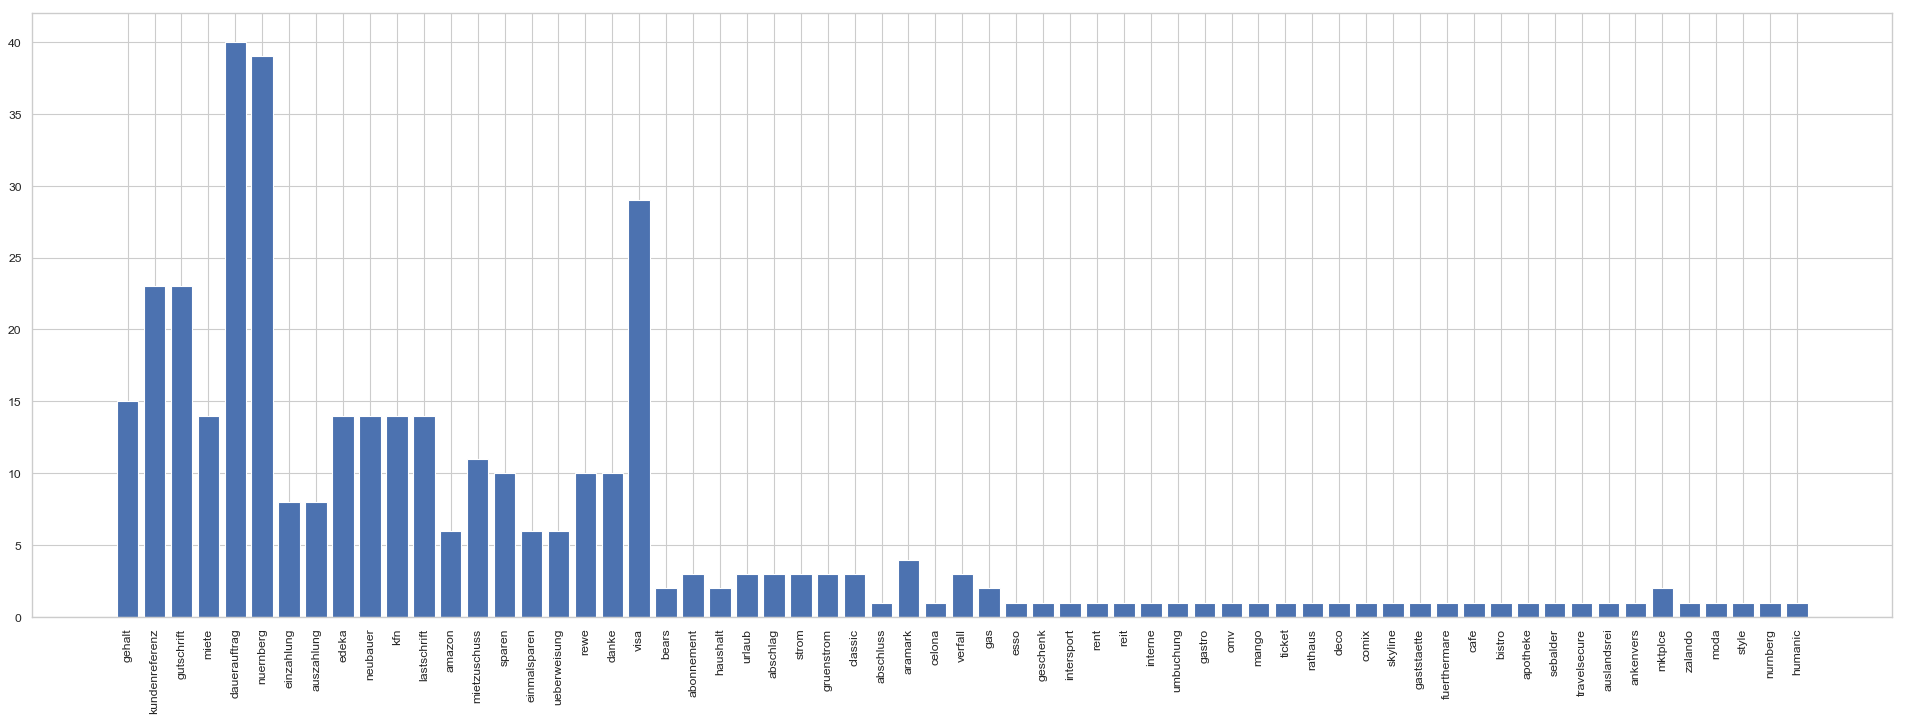

In [55]:
unwantedWords = "All Eur Geb Blz Nuernb Fil Folgenr Verf Alld ccbade xxx ccb spdude verfa lld pulsnitz elv maxx verfal " \
                "friends gmbAramark gmbh verfalld California Rfalld Doris Horst Dietrich Winkl Deutschland " \
                "rse Roethenbach Nuremberg Karolinen End adorsys Notprovided Nsct Byladem sbt ssknde Beuthener str Uhr " \
                "Nuerenberg Nuernber erg gries company ultra Schnieglin bil Fuerth ganz bequ www seon Lombagine Sebalder" \
                "Auslandsrei Sekr Icherung vero nbg koestr euro ref gmb"

unwantedWords = unwantedWords.split()
unwantedWords = [word.lower() for word in unwantedWords]
dataSetWithoutOutlier.Verwendungszweck = dataSetWithoutOutlier.Verwendungszweck.apply(lambda text: remove_words_from_text(text, unwantedWords))
testDataSetWithMeaningfulColumns.Verwendungszweck = testDataSetWithMeaningfulColumns.Verwendungszweck.apply(lambda text: remove_words_from_text(text, unwantedWords))
plot_token_frequencies(dataSetWithoutOutlier["Verwendungszweck"])


### Feature Engineering
* Now that the data is cleaner, we select, extract and transform the necessary features we will later feed into the model.


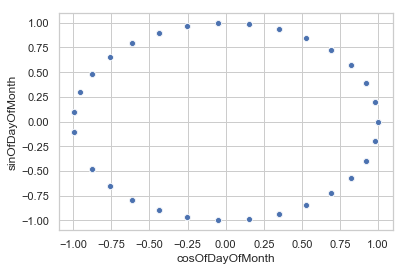

In [56]:
dataWithSelectedFeatures = pd.DataFrame()
testDataWithSelectedFeatures = pd.DataFrame()
dataWithSelectedFeatures["sinOfDayOfMonth"] = np.sin(dataSetWithoutOutlier.dayOfMonth*(2.0 * np.pi / 31))
testDataWithSelectedFeatures["sinOfDayOfMonth"] = np.sin(testDataSetWithMeaningfulColumns.dayOfMonth*(2.0 * np.pi / 31))
dataWithSelectedFeatures["cosOfDayOfMonth"] = np.cos(dataSetWithoutOutlier.dayOfMonth*(2.0 * np.pi / 31))
testDataWithSelectedFeatures["cosOfDayOfMonth"] = np.cos(testDataSetWithMeaningfulColumns.dayOfMonth*(2.0 * np.pi / 31))

dayOfMonthFeatures = sns.scatterplot(x="cosOfDayOfMonth", y="sinOfDayOfMonth", data=dataWithSelectedFeatures.sort_values("cosOfDayOfMonth"))


Now that the circular nature of dates has been captured in the two features **sinOfDayOfMonth** and **cosOfDayOfMonth**,
We now move next to the amount (Betrag).


In [57]:
print(dataSetWithoutOutlier.Betrag.describe())


count     180.000000
mean       23.504278
std       770.763909
min     -4000.000000
25%      -100.000000
50%       -28.850000
75%       -10.000000
max      2986.240000
Name: Betrag, dtype: float64


Betrag has a high standard deviation and variance. When the distribution of the amount was plotted, we noticed heavy 
tails. To stabilize the variance, we apply a log transformation. But before doing that, two more features will be 
extracted from the amount.
* A binary feature decimalInAmount that is 1 if the amount is not a whole number and 0 otherwise. 
For example, 1 for 23.56 and 0 for 23.00. This feature is extracted because (I speculate that) many transactions
like rent are often whole numbers, compared to leisure transactions.
* Since the log transformation only works for positive numbers, the sign of the amount must be extracted before.
(where 0 is considered positive to keep things simple). The sign is encoded as a binary feature.


,sinOfDayOfMonth,cosOfDayOfMonth,decimalInAmount,amountSign,absoluteAmount
0,-0.571268,0.820763,0,1,7.600902
1,-0.724793,0.688967,0,0,6.507278
2,-0.897805,-0.440394,0,0,4.248495
3,-0.790776,-0.612106,1,0,4.293332
4,-0.485302,-0.874347,0,0,5.894403


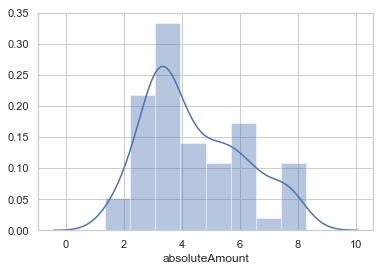

In [58]:
dataWithSelectedFeatures["decimalInAmount"] = [1 if amount - float(int(amount)) != 0. else 0 for amount in dataSetWithoutOutlier.Betrag]
testDataWithSelectedFeatures["decimalInAmount"] = [1 if amount - float(int(amount)) != 0. else 0 for amount in testDataSetWithMeaningfulColumns.Betrag]
dataWithSelectedFeatures["amountSign"] = dataSetWithoutOutlier.Betrag.apply(lambda s: 1 if s >= 0 else 0)
testDataWithSelectedFeatures["amountSign"] = testDataSetWithMeaningfulColumns.Betrag.apply(lambda s: 1 if s >= 0 else 0)
dataWithSelectedFeatures["absoluteAmount"] = dataSetWithoutOutlier.Betrag.apply(lambda a: np.log(np.abs(a)))
testDataWithSelectedFeatures["absoluteAmount"] = testDataSetWithMeaningfulColumns.Betrag.apply(lambda a: np.log(np.abs(a)))
absoluteAmountDistribution = sns.distplot(dataWithSelectedFeatures["absoluteAmount"])
dataWithSelectedFeatures.head()


This now looks a little better than what we had before (meaning the tails are gone and the distribution 
looks more normal).

We now convert **Buchungstext** and **Verwendungszweck** into a matrix of tokens. And we assume that 
the text consists of **german** words.


In [59]:
from sklearn.feature_extraction.text import CountVectorizer
def get_feature_matrix_from_corpus(corpus: pd.DataFrame) -> pd.DataFrame:
    vectorizer = CountVectorizer()
    text_matrix = vectorizer.fit_transform(corpus)
    text_features = vectorizer.get_feature_names()
    return pd.DataFrame(data=text_matrix.toarray(), columns=text_features)

vzAndBText = pd.DataFrame()
testVZAndBText = pd.DataFrame()
vzAndBText["vzAndBt"] = dataSetWithoutOutlier.Verwendungszweck + " " + dataSetWithoutOutlier.Buchungstext
testVZAndBText["vzAndBt"] = testDataSetWithMeaningfulColumns.Verwendungszweck + " " + testDataSetWithMeaningfulColumns.Buchungstext
vzAndBTextDF = get_feature_matrix_from_corpus(vzAndBText.vzAndBt)
testVZAndBText = get_feature_matrix_from_corpus(testVZAndBText.vzAndBt)


Some features here may be redundant, for example (**Lebensmittel**, **Getraenke**), 
(**Lastschrift**, **Einzugsermächtigung**) and (**Euro**, **Überweisung**). That is an assumption made based
on the current data. To have a model that generalizes better, I will drop (**Euro**, **Einzugsermächtigung** and
**Getraenke**) as special cases of the aforementioned (or maybe just mean the same). You can verify if you look at the 
distribution plotted earlier. 


In [60]:
vzAndBTextDF = vzAndBTextDF.drop(columns=["euro", "einzugsermaechtigung", "getraenke"])
testVZAndBText = testVZAndBText.drop(columns=["euro", "einzugsermaechtigung", "getraenke"])
vzAndBTextDF.head()


,abonnement,abschlag,abschluss,amazon,ankenvers,apotheke,aramark,ausland,auslandsrei,auszahlung,...,strom,style,ticket,travelsecure,ueberweisung,umbuchung,urlaub,verfall,visa,zalando
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The last raw feature is **Beguenstigter/Zahlungspflichtiger**. We are simply going to exclude this feature. Here is why:
* A name either belongs to a natural or legal person. This characteristic is partly handled by the keyword **Lastschrift**
since natural persons in europe very rare get SEPA Lastschrift. In other words, having the key word Lastschrift implicitly
mean the row transaction is for/from a company or firm.
* Another way to solve this would be to run Named Entity Recognition over the reference name column 
(**Beguenstigter/Zahlungspflichtiger**). I tried this indeed with **Zalando Flair** an Natural Language Processing
Library and had a percentage decrease of roughly **7%** (This could have been dependent on the run, but my assumption is
that keeping the names might just lead to overfitting. With more data, keeping it could have been an option).
Moreover, since **Flair** uses deep learning to extract entities,
it takes too much time. Hence I deleted it from this pipeline.


The operation above cost a lot of computational resources. This operation can thus be skipped to improve performance.
However, take note that the **isPersonalTransaction** feature will be absent when training.
Furthermore note that a name can be wrongly classified as person (e.g "Bargeld"), but my assumption is that binary 
values should generalize better than a long list of names.


Now we combine the features to get our final data frame


In [61]:
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(dataSetWithoutOutlier["label"])
encodedLabels = labelEncoder.transform(dataSetWithoutOutlier["label"])
testEncodedLabels = labelEncoder.transform(testDataSetWithMeaningfulColumns["label"])

def get_labels_as_data_frame(encoded_labels) -> pd.DataFrame:
    targets = pd.DataFrame()
    targets["label"] = encoded_labels
    targets["label"] = targets["label"].astype("int")
    return targets

labels = get_labels_as_data_frame(encodedLabels)
testLabels = get_labels_as_data_frame(testEncodedLabels)

dataWithSelectedFeatures.reset_index(drop=True, inplace=True)
testDataWithSelectedFeatures.reset_index(drop=True, inplace=True)
vzAndBTextDF.reset_index(drop=True, inplace=True)
testVZAndBText.reset_index(drop=True, inplace=True)
labels.reset_index(drop=True, inplace=True)
testLabels.reset_index(drop=True, inplace=True)
featuresAndLabels = pd.concat([dataWithSelectedFeatures, vzAndBTextDF, labels], axis=1, sort=False)
testFeaturesAndLabels = pd.concat([testDataWithSelectedFeatures, testVZAndBText, testLabels], axis=1, sort=False)
featuresAndLabels.head()


,sinOfDayOfMonth,cosOfDayOfMonth,decimalInAmount,amountSign,absoluteAmount,abonnement,abschlag,abschluss,amazon,ankenvers,...,style,ticket,travelsecure,ueberweisung,umbuchung,urlaub,verfall,visa,zalando,label
0,-0.571268,0.820763,0,1,7.600902,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,-0.724793,0.688967,0,0,6.507278,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,-0.897805,-0.440394,0,0,4.248495,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,-0.790776,-0.612106,1,0,4.293332,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
4,-0.485302,-0.874347,0,0,5.894403,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2


##### Automatic Feature selection 
Now we try to reduce the space using another feature selection technique called mutual information, which
measures the dependencies between two variables.


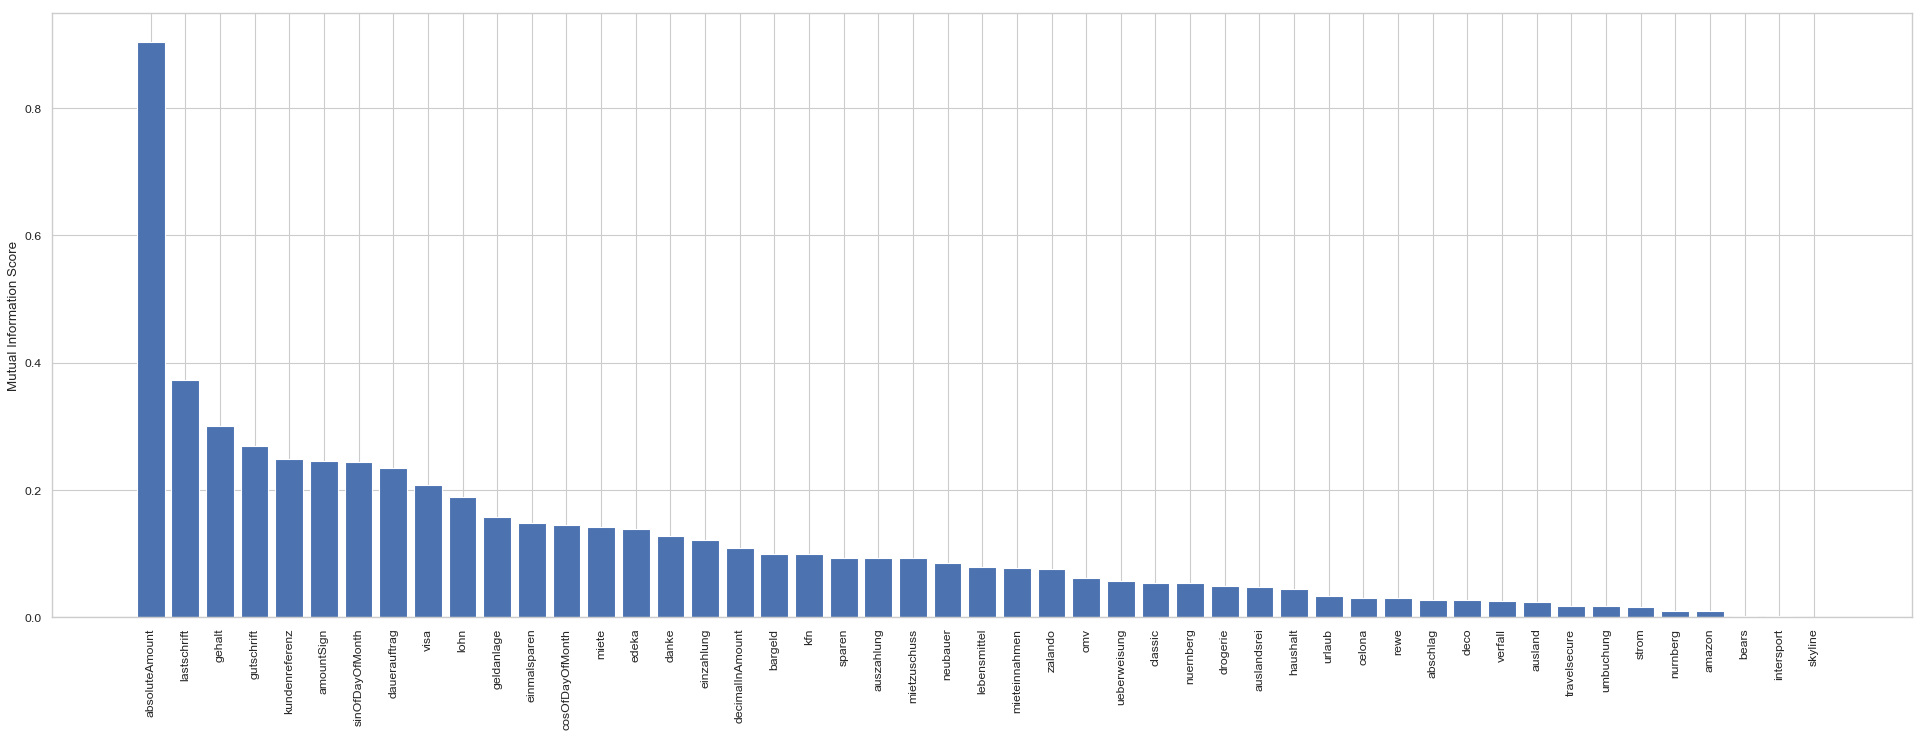

In [62]:
# Below re-coping and labels and features looks like a redundant task, but it is intended.
# The problem is that since we deleted an outlier, the labels and features indexes synced anymore.
# So we needed to merge and reorganize them first (that we did above). Now we can separate them back as before.
# I don't worry about memory since the data set is very small.
labels["label"] = featuresAndLabels["label"]
testLabels["label"] = testFeaturesAndLabels["label"]
features = featuresAndLabels.drop(columns=["label"])
testFeatures = testFeaturesAndLabels.drop(columns=["label"])
mIOfFeatures = mutual_info_classif(features, labels["label"], random_state=42, n_neighbors=4)
featureNames = list(features)
mIOfFeatures = list(zip(featureNames, mIOfFeatures))
mIOfFeatures.sort(key=lambda current_tuple: current_tuple[1], reverse=True) 
featureNames = [name for name, score in mIOfFeatures if score > 0]
mIScores = [score for _, score in mIOfFeatures if score > 0]
xPos = np.arange(len(featureNames))
figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
plt.bar(xPos, mIScores, align='center')
plt.xticks(xPos, featureNames, rotation='vertical') 
plt.ylabel('Mutual Information Score')
plt.show()
features = features[featureNames]
testFeatures = testFeatures[featureNames]

Above, I set n_neighbours to 4 reduce variance (which increases bias). In so doing, some features will
have a "**mi**" of 0. These features will then be deleted before training. 
A plot with the mutual information scores is shown above.


### Training and Evaluation
We train our data with a gaussian naive bayes classier. Scikit's implementation of this classifier can handle
(positive and negative) continuous values.


In [63]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

X_train, X_valid, y_train, y_valid = train_test_split(features, labels["label"], test_size=0.20, random_state=42)
classifier = GaussianNB().fit(X_train, y_train)
labels_predicted = classifier.predict(X_valid)
print("Accuracy: %0.2f " % np.mean(labels_predicted == y_valid))
precisionScore = metrics.precision_score(y_valid, y_pred=labels_predicted, average='macro')
recallScore = metrics.recall_score(y_valid, y_pred=labels_predicted, average='macro')
print("Precision: %0.2f " % precisionScore)
print("Recall: %0.2f " % recallScore)
np.set_printoptions(precision=2)


Accuracy: 0.89 
Precision: 0.94 
Recall: 0.91 


In [64]:
from sklearn.utils.multiclass import unique_labels

# This is a modified code snippet directly taken from scikit learn to draw the confusion matrix
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_normalized_confusion_matrix(y_true, y_pred, classes, normalize=True, cmap=plt.cm.Blues, title = 'Normalized confusion matrix'):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
    figr, axi = plt.subplots()
    im = axi.imshow(cm, interpolation='nearest', cmap=cmap)
    axi.figure.colorbar(im, ax=axi)
    axi.grid(False)
    # show all ticks...
    axi.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(axi.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axi.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    figr.tight_layout()
    return axi


Normalized confusion matrix


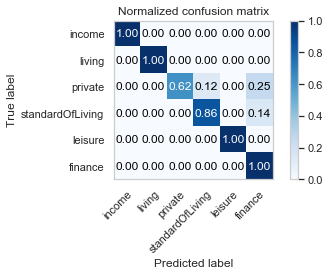

In [65]:
axes = plot_normalized_confusion_matrix(y_valid, labels_predicted, classes=dataSetWithoutOutlier["label"])
plt.show()


In [66]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit

n_samples = features.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

classifier = GaussianNB().fit(features, labels["label"])
scores = cross_val_score(classifier, features, labels["label"], cv=cv, scoring='accuracy')
f1Scores = cross_val_score(classifier, features, labels["label"], cv=cv, scoring='f1_macro')
precision = cross_val_score(classifier, features, labels["label"], cv=cv, scoring='precision_macro')
recall = cross_val_score(classifier, features, labels["label"], cv=cv, scoring='recall_macro')

print("Accuracy with Cross validation: %0.2f " % scores.mean())
print("F1 score with Cross validation: %0.2f " % f1Scores.mean())
print("Precision with Cross validation: %0.2f " % precision.mean())
print("Recall with Cross validation: %0.2f " % recall.mean())


Accuracy with Cross validation: 0.81 
F1 score with Cross validation: 0.81 
Precision with Cross validation: 0.84 
Recall with Cross validation: 0.81 


After training, we obtain an accuracy of 89% which in my opinion is overrated. To get fairer metrics,
I ran it again with cross validation. The average accuracy then sank to 81%. I also print the F1-Measure
since our class distribution since accuracy does not do as well with imbalanced data. Precision and Recall 
are also added for completeness.



### Testing
Now we test the model with **unseen** data. Recall that the test data was processed on the fly, next to the training data.
But it had no influence on the parameters. We evaluate our test and print out scores like we did above.
 

Accuracy: 0.84 
Precision: 0.86 
Recall: 0.86 
Normalized confusion matrix


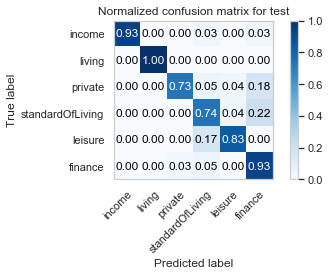

In [67]:

testLabelsPredicted = classifier.predict(testFeatures)
print("Accuracy: %0.2f " % np.mean(testLabelsPredicted == testLabels["label"]))
precisionScore = metrics.precision_score(testLabels["label"], y_pred=testLabelsPredicted, average='macro')
recallScore = metrics.recall_score(testLabels["label"], y_pred=testLabelsPredicted, average='macro')
print("Precision: %0.2f " % precisionScore)
print("Recall: %0.2f " % recallScore)
test_axes = plot_normalized_confusion_matrix(testLabels["label"], testLabelsPredicted, classes=testDataSetWithMeaningfulColumns["label"], title = 'Normalized confusion matrix for test')
plt.show()


Above we notice that the prediction scores are even better than our cross validation scores. But worse compared the scores
computed without cross validation, which again shows that our cross validation scores are fairer.

Our top (best) 3 performing classes are **living**, **income** and **finance**
The worst performing class is **private**.